In [1]:
import numpy as np
import pandas as pd

In [13]:
data = pd.read_csv('/Users/JohnWishart/Desktop/Electric_Production.csv')
data.rename(columns={'DATE':'date','IPG2211A2N':'production'},inplace=True)
data.tail()

,date,production
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212
396,1/1/2018,129.4048


In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
production,397.0,88.847218,15.387834,55.3151,77.1052,89.7795,100.5244,129.4048


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        397 non-null    object 
 1   production  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [16]:
data.isnull().sum()

date          0
production    0
dtype: int64

In [17]:
data['date'] = pd.to_datetime(data.date)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        397 non-null    datetime64[ns]
 1   production  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [18]:
data.set_index('date' ,inplace=True)


<Axes: xlabel='date'>

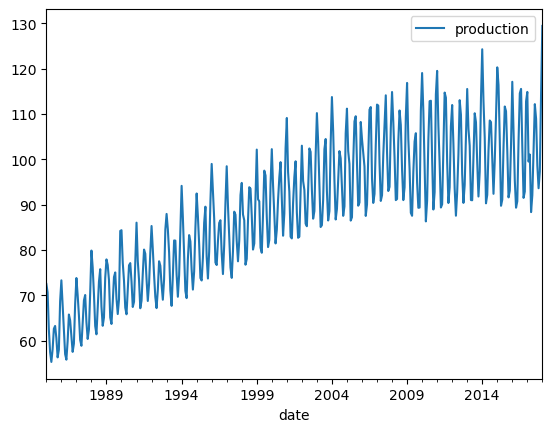

In [19]:
data[['production']].plot()

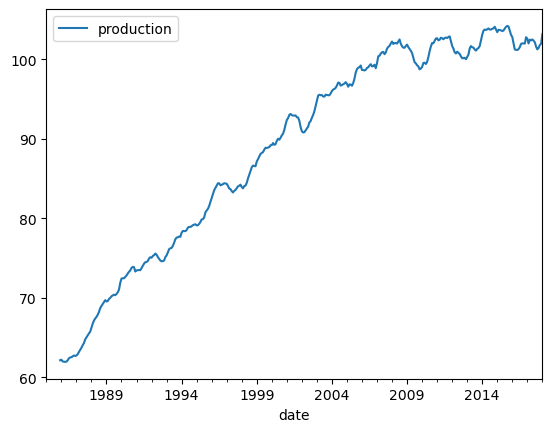

In [20]:
data_roll_production =data[['production']].rolling(12).mean().plot()

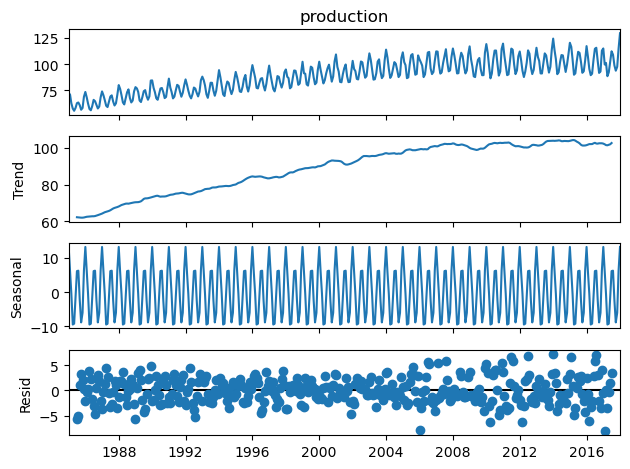

In [21]:
# Data decomposition
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(x=data['production'],model='additive',period=12)
decomposition.plot()
plt.show()

In [22]:
data.shape

(397, 1)

In [23]:
# create test and train set
electric_df_test = data[['production']].iloc[275:]
electric_df_train = data[['production']].iloc[:274]

In [24]:
electric_df_train.shape, electric_df_test.shape

((274, 1), (122, 1))

In [26]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(electric_df_train['production'],order=(2,1,3)).fit()

# # provide an alternative to the order parameter
# from pmdarima import auto_arima
# auto_arima_model = auto_arima(electric_df_train['production'],start_p=0,start_q=0,max_p=5,max_q=5,seasonal=False,trace=True)


/Users/johnwishart/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/johnwishart/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/johnwishart/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/johnwishart/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/johnwishart/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='date'>

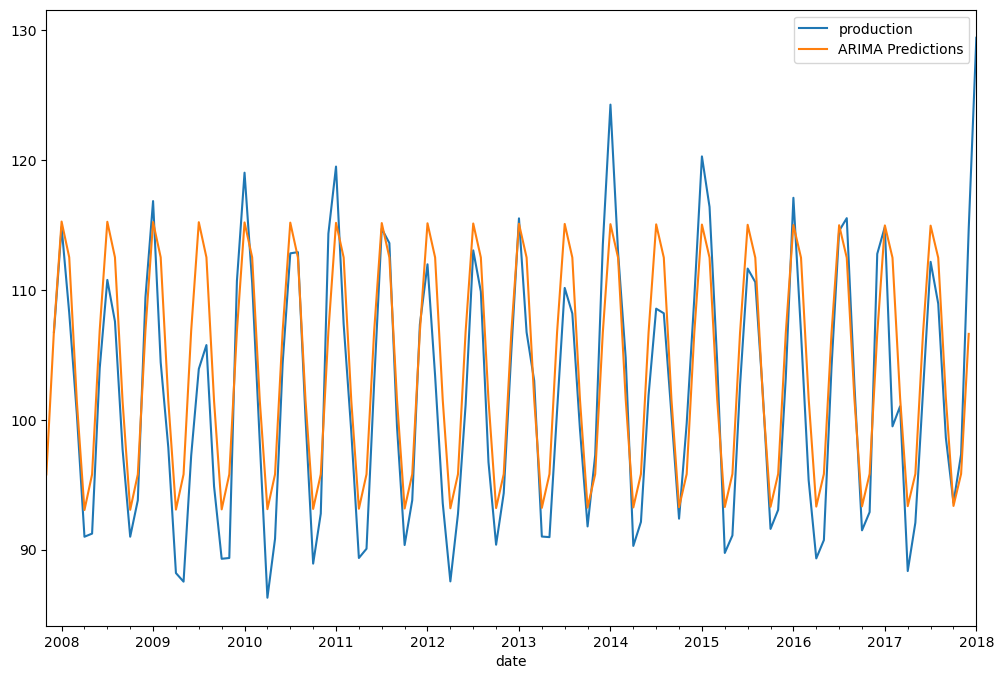

In [28]:
# develop predictions first
start = len(electric_df_train)
end = len(electric_df_train) + len(electric_df_test) - 1
predictions = arima_model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
# plot
electric_df_test['production'].plot(legend=True,figsize=(12,8))
predictions.plot(legend=True)



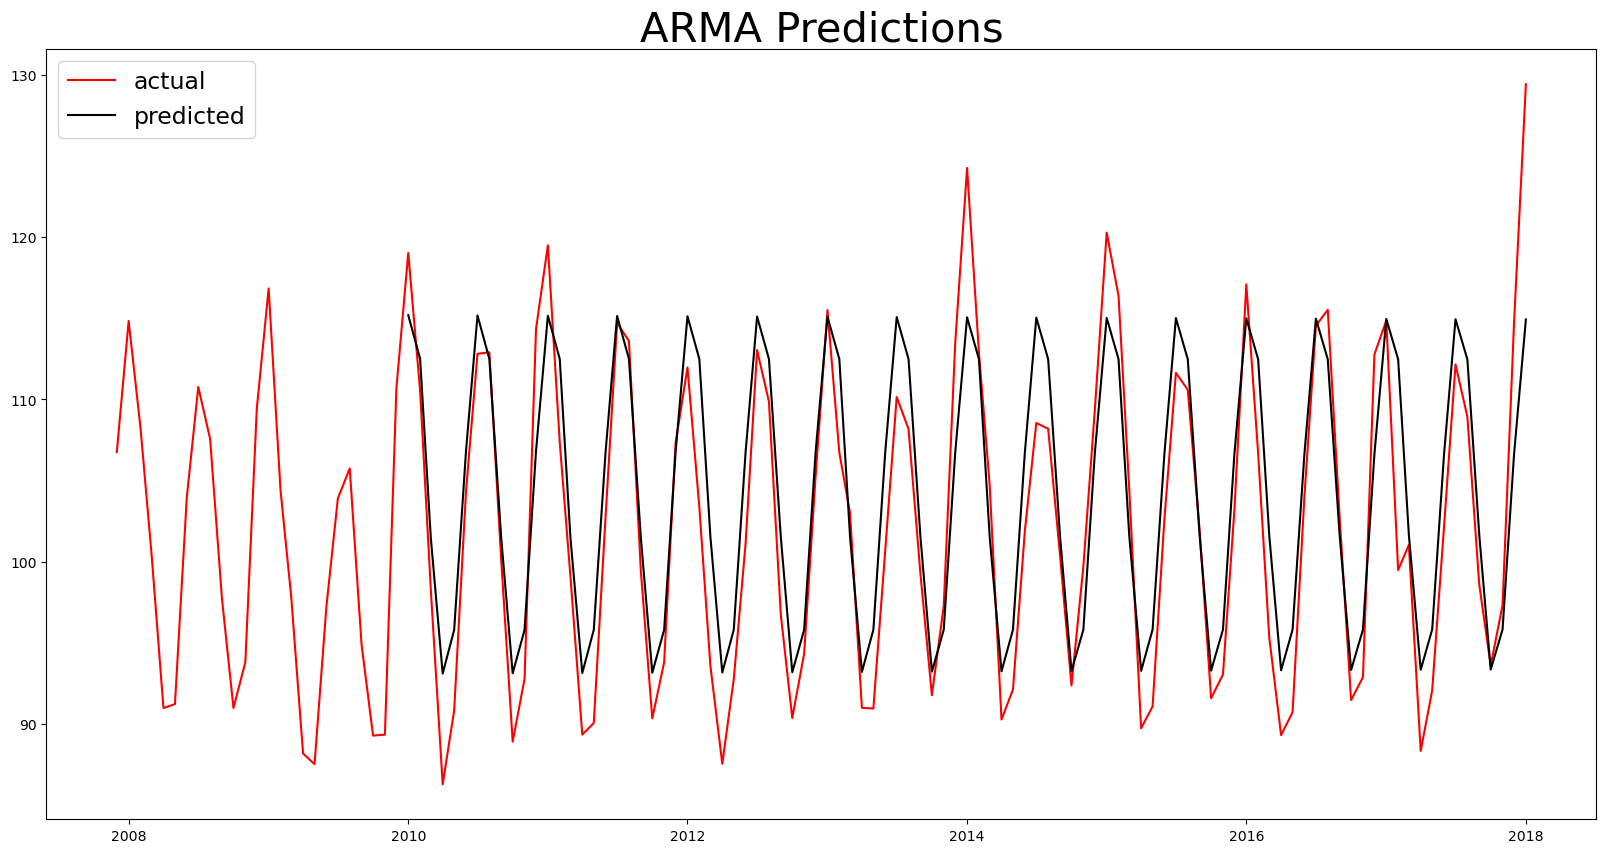

In [32]:
# develop preidctions second
electric_df_pred = arima_model.predict(start= 300 , end= 396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARMA Predictions', fontsize=30)
plt.plot(electric_df_test['production'], label='actual', color='red')
plt.plot(electric_df_pred, label='predicted', color='black')
plt.legend(fontsize =17, loc='upper left')

In [33]:
# 5 period data forecast
arima_model.forecast(5)

2007-11-01     95.791176
2007-12-01    106.899792
2008-01-01    115.253806
2008-02-01    112.504455
2008-03-01    101.404177
Freq: MS, Name: predicted_mean, dtype: float64

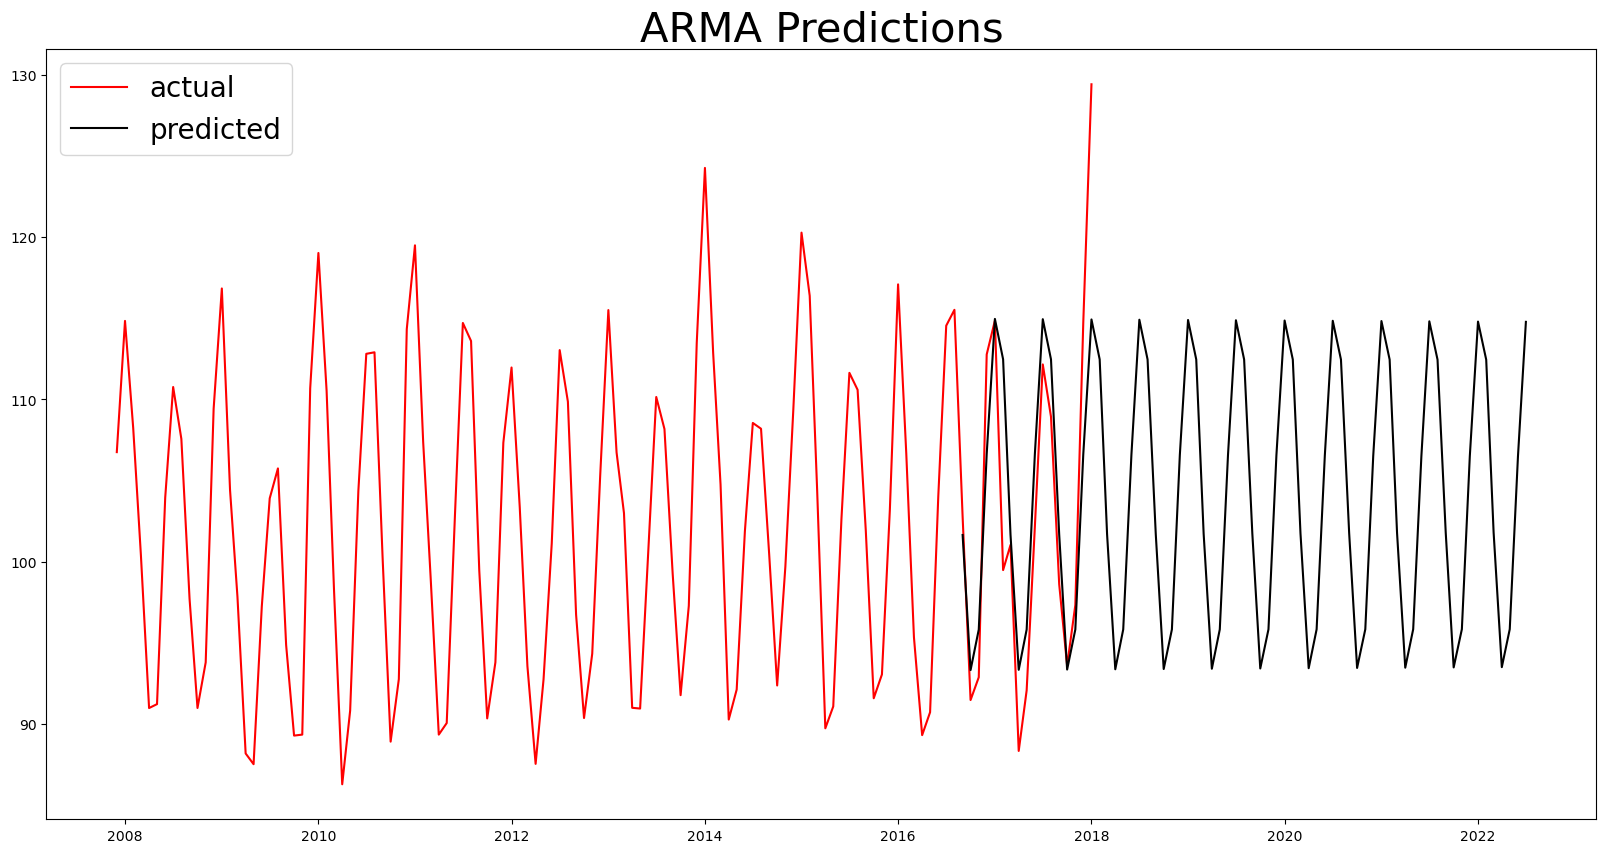

In [35]:
df_pred_upper_dataset = arima_model.predict(start= 380 , end= 450)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARMA Predictions', fontsize=30)
plt.plot(electric_df_test['production'], label='actual', color='red')
plt.plot(df_pred_upper_dataset, label='predicted', color='black')
plt.legend(fontsize =20, loc='upper left')

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [37]:
rmse = sqrt(mean_squared_error(electric_df_test['production'], predictions))
rmse
# explanation of the RMSE
# The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model's predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.
# results of 10.02 indicate that the model is off by 10.02 units on average


10.028150099102279

In [38]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  274
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -697.607
Date:                Sun, 04 Feb 2024   AIC                           1407.213
Time:                        14:57:37   BIC                           1428.870
Sample:                    01-01-1985   HQIC                          1415.907
                         - 10-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0001      0.002    480.497      0.000       0.996       1.004
ar.L2         -0.9996      0.001  -1165.600      0.000      -1.001      -0.998
ma.L1         -1.1904      0.058    -20.673      0.000      -1.303      -1.078
ma.L2          1.1314      0.065     17.438      0.000       1.004       1.259
ma.L3         -0.1381      0.057     -2.422      0.015      -0.250      -0.026
sigma2         9.3381      0.777     12.015      0.000       7.815      10.861
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.90   Prob(JB):                         0.31
Heteroskedasticity (H):               1.91   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""